In [23]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
import matplotlib.patches as patches
import cv2
import pandas as pd
import sys
import poissonimageediting as poisson
from tqdm.auto import tqdm
# import torch
# from pietorch.functional import blend, blend_wide
# from torchvision.transforms import functional as TF
from PIL import Image
import os
np.set_printoptions(threshold=sys.maxsize)

In [24]:
image = cv2.imread('data/01.jpg').astype(np.uint8)
dataset_images_dir = "data/holiday_images"
target_df = pd.read_pickle('data/target_df.pkl')
dataset_df = pd.read_pickle('data/holiday_df.pkl')

In [25]:
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

target_descriptors = np.array(target_df['descriptor'].tolist(), dtype = np.float32)
dataset_descriptors = np.array(dataset_df['descriptor'].tolist(), dtype = np.float32)

matches = matcher.match(target_descriptors, dataset_descriptors)

target_df['match_idx'] = np.array([match.trainIdx for match in matches])

In [27]:
target_df = target_df.sort_values(by = ['size'], ascending = [False])
# filter size that is too small
target_df_filtered = target_df[target_df['size'] > 2000]
print(target_df_filtered.shape)

(2204, 13)


In [28]:
dataset_df.shape


(259653, 12)

In [29]:
def warp_and_paste_ellipse(source_image_path, destination_image, source_params, destination_params):
    # Load the source and destination images
    source_image = cv2.imread(source_image_path).astype(np.uint8)
    # source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2Lab)

    # Unpack ellipse parameters
    u, v, major_axis_length, minor_axis_length, angle = source_params
    u2, v2, major_axis_length2, minor_axis_length2, angle2 = destination_params

    # Define the source ellipse parameters (from the source image)
    center1 = (int(u), int(v))
    axes1 = (int(major_axis_length), int(minor_axis_length))
    angle1 = np.degrees(angle)

    # Define the destination ellipse parameters (on the destination image)
    center2 = (int(u2), int(v2))
    axes2 = (int(major_axis_length2), int(minor_axis_length2))
    angle2 = np.degrees(angle2)

    # Create a mask for the source ellipse
    mask = np.zeros_like(source_image)
    cv2.ellipse(mask, center1, axes1, angle1, 0, 360, (255, 255, 255), -1)

    # Extract the source ellipse region
    source_ellipse_region = cv2.bitwise_and(source_image, mask)

    # Define the bounding box around the source ellipse
    src_rect = cv2.boxPoints(((center1[0], center1[1]), (axes1[0] * 2, axes1[1] * 2), angle1))
    src_rect = np.int0(src_rect)

    # Define the bounding box around the destination ellipse
    dst_rect = cv2.boxPoints(((center2[0], center2[1]), (axes2[0] * 2, axes2[1] * 2), angle2))
    dst_rect = np.int0(dst_rect)

    # Compute the perspective transformation matrix
    M = cv2.getPerspectiveTransform(np.float32(src_rect), np.float32(dst_rect))

    # Warp the source ellipse region to the shape of the destination ellipse
    warped_ellipse_region = cv2.warpPerspective(source_ellipse_region, M, (destination_image.shape[1], destination_image.shape[0]))
    


    # Get the bounding box of the destination ellipse
    x, y, w, h = cv2.boundingRect(dst_rect)

    # Crop the warped source ellipse to its bounding box
    warped_source_ellipse_bbox = warped_ellipse_region[y:y+h, x:x+w]
    # color
    # if (warped_source_ellipse_bbox.shape[0] != 0) and (warped_source_ellipse_bbox.shape[1] != 0):
    #     warped_source_ellipse_bbox = cv2.cvtColor(warped_source_ellipse_bbox, cv2.COLOR_BGR2RGB)
    
    # get the top left corner points of the bounding box in the image
    corner = (x, y)
    
    return warped_source_ellipse_bbox, corner

In [30]:
def poisson_blend(ellipse, canvas, mask, center):
    # Convert images to float32
    ellipse = ellipse.astype(np.float32) / 255.0
    canvas = canvas.astype(np.float32) / 255.0
    mask = mask.astype(np.float32) / 255.0

    # Split the images into their color channels
    ellipse_channels = cv2.split(ellipse)
    canvas_channels = cv2.split(canvas)
    # mask_channels = cv2.split(mask)
    
    # Resultant blended channels
    blended_channels = []

    for i in range(3):  # Assuming 3 color channels
        blended_channel = cv2.seamlessClone(
            ellipse_channels[i],
            canvas_channels[i],
            mask,
            center,
            cv2.NORMAL_CLONE
        )
        blended_channels.append(blended_channel)

    # Merge the blended channels back into one image
    blended_image = cv2.merge(blended_channels)

    # Convert the image back to uint8
    blended_image = (blended_image * 255).astype(np.uint8)

    return blended_image

In [22]:
canvas = np.zeros_like(image).astype(np.uint8)
# convert canvas to lab
canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
# canvas = image.copy().astype(np.uint8)
# canvas_l = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
# canvas_a = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
# canvas_b = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
# use enumerate to get the index of the row

# Iterate through the filtered DataFrame
for i, (index, row) in enumerate(tqdm(target_df_filtered.iterrows(), total=target_df_filtered.shape[0])):
    # canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
    target_u, target_v = row['coordinate']
    target_A = row['matrix']
    target_major_axis_length = row['semi_major_axis']
    target_minor_axis_length = row['semi_minor_axis']
    target_angle = row['angle']
    
    match_idx = row['match_idx']
    match_image_name = dataset_df.loc[match_idx, 'image_name']
    match_u, match_v = dataset_df.loc[match_idx, 'coordinate']
    match_A = np.array(dataset_df.loc[match_idx, 'matrix'])
    match_major_axis_length = dataset_df.loc[match_idx, 'semi_major_axis']
    match_minor_axis_length = dataset_df.loc[match_idx, 'semi_minor_axis']
    match_angle = dataset_df.loc[match_idx, 'angle']
    
    match_image_path = f"{dataset_images_dir}/{match_image_name}"
    
    source_params = (match_u, match_v, match_major_axis_length, match_minor_axis_length, match_angle)
    destination_params = (target_u, target_v, target_major_axis_length, target_minor_axis_length, target_angle)

    ellipse, corner = warp_and_paste_ellipse(match_image_path, canvas, source_params, destination_params)
    ellipse = ellipse.astype(np.uint8) 
    
    if ellipse is not None:
        # Get top-left corner coordinates
        x, y = corner
        
        # Check if there is overlap
        canvas_region = canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]]
        # if ellipse.shape[-1] == 4:  # If ellipse has an alpha channel
        #     ellipse_mask = (ellipse[..., 3] > 0).astype(np.uint8) * 255
        # else:  # If ellipse does not have an alpha channel
        #     ellipse_mask = (ellipse != 0).all(axis=2).astype(np.uint8) * 255
        ellipse_mask = (ellipse != 0).astype(np.uint8) * 255
            
        
        if np.count_nonzero(canvas_region) == 0:
    # Ensure the mask is applied only where the mask is non-zero
            # for c in range(0, 3):  # Loop over the color channels (B, G, R)
            #     canvas_region[..., c] = np.where(ellipse_mask != 0, ellipse[..., c], canvas_region[..., c])
            canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]] = ellipse
            
    # Assign the modified region back to the canvas
    # canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]] = canvas_region
        # expand the mask to the shape of canvas

        else:
            # Blending the overlappint with seamlessClone
            # save the ellipse to image
            # cv2.imwrite("ellipse.png", ellipse)
            # # read ellipse
            # ellipse = cv2.imread("ellipse.png")
            # ellipse_mask = np.ones_like(ellipse) * 255
            
            # extract red channel of the ellipse
            ellipse_lab = cv2.cvtColor(ellipse, cv2.COLOR_BGR2Lab)
            
            # split lab channel
            ellipse_l, ellipse_a, ellipse_b = cv2.split(ellipse_lab)
            ellipse_l_3c = cv2.merge([ellipse_l, ellipse_l, ellipse_l])
            ellipse_a_3c = cv2.merge([ellipse_a, ellipse_a, ellipse_a])
            ellipse_b_3c = cv2.merge([ellipse_b, ellipse_b, ellipse_b])
            
            canvas_l, canvas_a, canvas_b = cv2.split(canvas)
            canvas_l_3c = cv2.merge([canvas_l, canvas_l, canvas_l])
            canvas_a_3c = cv2.merge([canvas_a, canvas_a, canvas_a])
            canvas_b_3c = cv2.merge([canvas_b, canvas_b, canvas_b])
            
            center = (x + ellipse.shape[1] // 2, y + ellipse.shape[0] // 2)
            
            result_l = cv2.seamlessClone(ellipse_l_3c, canvas_l_3c, ellipse_mask, center, cv2.MIXED_CLONE)
            result_a = cv2.seamlessClone(ellipse_a_3c, canvas_a_3c, ellipse_mask, center, cv2.MIXED_CLONE)
            result_b = cv2.seamlessClone(ellipse_b_3c, canvas_b_3c, ellipse_mask, center, cv2.MIXED_CLONE)
            
            result_l = cv2.split(result_l)[0]
            result_a = cv2.split(result_a)[0]
            result_b = cv2.split(result_b)[0]
            
            result = cv2.merge([result_l, result_a, result_b])
            # result = cv2.seamlessClone(ellipse, canvas, ellipse_mask, center, cv2.MIXED_CLONE)
            # result = cv2.seamlessClone(ellipse_lab, canvas, ellipse_mask, center, cv2.MIXED_CLONE)
            # canvas = cv2.merge([result_b, result_b, result_b])
            canvas = result
            
            
        
        # normalized the canvas
        # canvas = cv2.normalize(canvas, None, 0, 255, cv2.NORM_MINMAX)
            
        output_image = cv2.cvtColor(canvas, cv2.COLOR_Lab2BGR)
            
            # other part of the image will be the ellipse
        # Save the canvas every iteration
        # create output folder if not exist
        if not os.path.exists('output'):
            os.makedirs('output')
        cv2.imwrite(f'output/output_{i:03d}.png', output_image)
        
        # if(i>0):
        #     break

  0%|          | 0/1357 [00:00<?, ?it/s]/tmp/ipykernel_7688/2246133766.py:29: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  src_rect = np.int0(src_rect)
/tmp/ipykernel_7688/2246133766.py:33: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  dst_rect = np.int0(dst_rect)
 23%|██▎       | 314/1357 [00:59<03:18,  5.24it/s]


KeyboardInterrupt: 

In [31]:
canvas = np.zeros_like(image).astype(np.uint8)
canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
# convert canvas to lab
# canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
# canvas = image.copy().astype(np.uint8)
canvas_l_3c = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
canvas_a_3c = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
canvas_b_3c = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
# use enumerate to get the index of the row

# Iterate through the filtered DataFrame
for i, (index, row) in enumerate(tqdm(target_df_filtered.iterrows(), total=target_df_filtered.shape[0])):
    # canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2Lab)
    target_u, target_v = row['coordinate']
    target_A = row['matrix']
    target_major_axis_length = row['semi_major_axis']
    target_minor_axis_length = row['semi_minor_axis']
    target_angle = row['angle']
    
    match_idx = row['match_idx']
    match_image_name = dataset_df.loc[match_idx, 'image_name']
    match_u, match_v = dataset_df.loc[match_idx, 'coordinate']
    match_A = np.array(dataset_df.loc[match_idx, 'matrix'])
    match_major_axis_length = dataset_df.loc[match_idx, 'semi_major_axis']
    match_minor_axis_length = dataset_df.loc[match_idx, 'semi_minor_axis']
    match_angle = dataset_df.loc[match_idx, 'angle']
    
    match_image_path = f"{dataset_images_dir}/{match_image_name}"
    
    source_params = (match_u, match_v, match_major_axis_length, match_minor_axis_length, match_angle)
    destination_params = (target_u, target_v, target_major_axis_length, target_minor_axis_length, target_angle)

    ellipse, corner = warp_and_paste_ellipse(match_image_path, canvas, source_params, destination_params)
    ellipse = ellipse.astype(np.uint8) 
    
    
    if ellipse is not None and ellipse.shape[0] != 0 and ellipse.shape[1] != 0:
        # Get top-left corner coordinates

        ellipse_lab = cv2.cvtColor(ellipse, cv2.COLOR_BGR2Lab)
    # split lab channel
        ellipse_l, ellipse_a, ellipse_b = cv2.split(ellipse_lab)
        ellipse_l_3c = cv2.merge([ellipse_l, ellipse_l, ellipse_l])
        ellipse_a_3c = cv2.merge([ellipse_a, ellipse_a, ellipse_a])
        ellipse_b_3c = cv2.merge([ellipse_b, ellipse_b, ellipse_b])
        
        
        x, y = corner
        
        # Check if there is overlap
        canvas_region = canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]]
        # if ellipse.shape[-1] == 4:  # If ellipse has an alpha channel
        #     ellipse_mask = (ellipse[..., 3] > 0).astype(np.uint8) * 255
        # else:  # If ellipse does not have an alpha channel
        #     ellipse_mask = (ellipse != 0).all(axis=2).astype(np.uint8) * 255
        ellipse_mask = (ellipse != 0).astype(np.uint8) * 255
            
        
        if np.count_nonzero(canvas_region) == 0:
    # Ensure the mask is applied only where the mask is non-zero
            # for c in range(0, 3):  # Loop over the color channels (B, G, R)
            #     canvas_region[..., c] = np.where(ellipse_mask != 0, ellipse[..., c], canvas_region[..., c])
            
            canvas_b_3c[y:y+ellipse.shape[0], x:x+ellipse.shape[1]] = ellipse_b_3c
            canvas_a_3c[y:y+ellipse.shape[0], x:x+ellipse.shape[1]] = ellipse_a_3c
            canvas_l_3c[y:y+ellipse.shape[0], x:x+ellipse.shape[1]] = ellipse_l_3c
            
    # Assign the modified region back to the canvas
    # canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]] = canvas_region
        # expand the mask to the shape of canvas

        else:
            # canvas_l, canvas_a, canvas_b = cv2.split(canvas)
            # canvas_l_3c = cv2.merge([canvas_l, canvas_l, canvas_l])
            # canvas_a_3c = cv2.merge([canvas_a, canvas_a, canvas_a])
            # canvas_b_3c = cv2.merge([canvas_b, canvas_b, canvas_b])
            
            center = (x + ellipse.shape[1] // 2, y + ellipse.shape[0] // 2)
            
            result_l = cv2.seamlessClone(ellipse_l_3c, canvas_l_3c, ellipse_mask, center, cv2.MIXED_CLONE)
            result_a = cv2.seamlessClone(ellipse_a_3c, canvas_a_3c, ellipse_mask, center, cv2.MIXED_CLONE)
            result_b = cv2.seamlessClone(ellipse_b_3c, canvas_b_3c, ellipse_mask, center, cv2.MIXED_CLONE)
            
            # result_l = cv2.split(result_l)[0]
            # result_a = cv2.split(result_a)[0]
            # result_b = cv2.split(result_b)[0]
            
            # result = cv2.merge([result_l, result_a, result_b])
            # result = cv2.seamlessClone(ellipse, canvas, ellipse_mask, center, cv2.MIXED_CLONE)
            # result = cv2.seamlessClone(ellipse_lab, canvas, ellipse_mask, center, cv2.MIXED_CLONE)
            # canvas = cv2.merge([result_b, result_b, result_b])
            canvas_l_3c = result_l
            canvas_a_3c = result_a
            canvas_b_3c = result_b
            
            
        
        # normalized the canvas
        # canvas = cv2.normalize(canvas, None, 0, 255, cv2.NORM_MINMAX)
        canvas_output = cv2.merge([cv2.split(canvas_l_3c)[0], cv2.split(canvas_a_3c)[0], cv2.split(canvas_b_3c)[0]])
        output_image = cv2.cvtColor(canvas_output, cv2.COLOR_Lab2BGR)
            
            # other part of the image will be the ellipse
        # Save the canvas every iteration
        # create output folder if not exist
        if not os.path.exists('output'):
            os.makedirs('output')
        cv2.imwrite(f'output/output_{i:03d}.png', output_image)
        
        # if(i>0):
        #     break

  0%|          | 0/2204 [00:00<?, ?it/s]

/tmp/ipykernel_7688/2246133766.py:29: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  src_rect = np.int0(src_rect)
/tmp/ipykernel_7688/2246133766.py:33: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  dst_rect = np.int0(dst_rect)
  1%|          | 17/2204 [00:07<15:58,  2.28it/s] 


KeyboardInterrupt: 

In [11]:
ellipse.shape

(0, 1460, 3)

In [93]:
ellipse_mask = (ellipse != 0).astype(np.uint8)

In [115]:
ellipse_mask.shape

(962, 1128, 3)

In [96]:
mask.shape

(640, 794, 3)

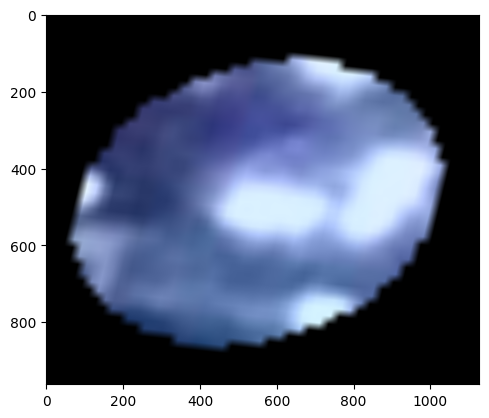

In [103]:

plt.imshow(ellipse)

In [51]:
ellipse_mask

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0